In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, 
                           roc_curve, precision_recall_curve, f1_score, accuracy_score,
                           precision_score, recall_score, average_precision_score)

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, 
                            AdaBoostClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load the dataset
df = pd.read_csv('Loan_default.csv')

In [5]:
# Separate features and target
X = df.drop(['LoanID', 'Default'], axis=1)  # Remove ID and target
y = df['Default']

In [7]:
# Identify numerical and categorical columns
numerical_features = ['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed', 
                     'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio']

categorical_features = ['Education', 'EmploymentType', 'MaritalStatus', 'HasMortgage', 
                       'HasDependents', 'LoanPurpose', 'HasCoSigner']

In [9]:
# Create preprocessing pipelines
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first', sparse_output=False)

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [13]:
# Define models to compare
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(random_state=42, verbose=-1),
    'Extra Trees': ExtraTreesClassifier(random_state=42, n_jobs=-1),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'Neural Network': MLPClassifier(random_state=42, max_iter=500)
}

In [15]:
# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [17]:
results = {}
cv_scores = {}

In [19]:
for name, model in models.items():
    # Create pipeline with preprocessing
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    try:
        # Perform cross-validation
        import time
        start_time = time.time()
        scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
        train_time = time.time() - start_time
        
        # Store results
        results[name] = {
            'mean_score': scores.mean(),
            'std_score': scores.std(),
            'train_time': train_time
        }
        cv_scores[name] = scores
        
        print(f"{name:<20} {scores.mean():<15.4f} {scores.std():<15.4f} {train_time:<15.2f}s")
        
    except Exception as e:
        print(f"{name:<20} ERROR: {str(e)}")
        results[name] = {'mean_score': 0, 'std_score': 0, 'train_time': 0}

Logistic Regression  0.7463          0.0039          1.78           s
Decision Tree        0.5527          0.0037          2.75           s
Random Forest        0.7265          0.0048          13.24          s
Gradient Boosting    0.7511          0.0027          30.05          s
XGBoost              0.7358          0.0035          2.15           s
LightGBM             0.7506          0.0027          5.92           s
Extra Trees          0.7251          0.0025          9.39           s


/Users/binaypandey/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/binaypandey/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/binaypandey/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/binaypandey/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorit

AdaBoost             0.7457          0.0035          7.63           s
KNN                  0.6159          0.0026          20.02          s
Naive Bayes          0.7434          0.0036          1.31           s
Neural Network       0.7399          0.0032          28.55          s


In [20]:
# Sort models by performance
sorted_models = sorted(results.items(), key=lambda x: x[1]['mean_score'], reverse=True)

In [23]:
for i, (name, metrics) in enumerate(sorted_models[:8], 1):
    print(f"{i}. {name}: {metrics['mean_score']:.4f} (±{metrics['std_score']:.4f})")

# Select top 8 models for hyperparameter tuning
top_models = [model[0] for model in sorted_models[:8]]
print(f"\nSelected for hyperparameter tuning: {top_models}")

1. Gradient Boosting: 0.7511 (±0.0027)
2. LightGBM: 0.7506 (±0.0027)
3. Logistic Regression: 0.7463 (±0.0039)
4. AdaBoost: 0.7457 (±0.0035)
5. Naive Bayes: 0.7434 (±0.0036)
6. Neural Network: 0.7399 (±0.0032)
7. XGBoost: 0.7358 (±0.0035)
8. Random Forest: 0.7265 (±0.0048)

Selected for hyperparameter tuning: ['Gradient Boosting', 'LightGBM', 'Logistic Regression', 'AdaBoost', 'Naive Bayes', 'Neural Network', 'XGBoost', 'Random Forest']


In [25]:
# 6. HYPERPARAMETER TUNING
print("\n6. HYPERPARAMETER TUNING")
print("-" * 40)

# Define hyperparameter grids for top models
param_grids = {
    'Logistic Regression': {
        'classifier__C': [0.01, 0.1, 1, 10, 100],
        'classifier__penalty': ['l1', 'l2'],
        'classifier__solver': ['liblinear', 'saga'],
        'classifier__max_iter': [1000, 2000]
    },
    'Decision Tree': {
        'classifier__max_depth': [5, 10, 15, 20, None],
        'classifier__min_samples_split': [2, 5, 10, 20],
        'classifier__min_samples_leaf': [1, 2, 5, 10],
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__max_features': ['sqrt', 'log2', None]
    },
    'Random Forest': {
        'classifier__n_estimators': [100, 200, 300, 500],
        'classifier__max_depth': [10, 20, 30, None],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4],
        'classifier__max_features': ['sqrt', 'log2'],
        'classifier__bootstrap': [True, False]
    },
    'Gradient Boosting': {
        'classifier__n_estimators': [50, 100,200],
        'classifier__max_depth': [3, 5,7],
        'classifier__learning_rate': [0.1, 0.2],
        'classifier__subsample': [0.8]
        #'classifier__min_samples_split': [2, 5, 10],
        #'classifier__min_samples_leaf': [1, 2, 4]
    },
    'XGBoost': {
        'classifier__n_estimators': [100, 200, 300, 500],
        'classifier__max_depth': [3, 6, 10, 15],
        'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],
        'classifier__subsample': [0.8, 0.9, 1.0],
        'classifier__colsample_bytree': [0.8, 0.9, 1.0],
        'classifier__reg_alpha': [0, 0.1, 1],
        'classifier__reg_lambda': [1, 1.5, 2]
    },
    'LightGBM': {
        'classifier__n_estimators': [100, 200, 300, 500],
        'classifier__max_depth': [3, 5, 7, 10],
        'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],
        'classifier__subsample': [0.8, 0.9, 1.0],
        'classifier__feature_fraction': [0.8, 0.9, 1.0],
        'classifier__reg_alpha': [0, 0.1, 1],
        'classifier__reg_lambda': [0, 0.1, 1],
        'classifier__min_child_samples': [20, 30, 50]
    },
    'Extra Trees': {
        'classifier__n_estimators': [100, 200, 300, 500],
        'classifier__max_depth': [10, 20, 30, None],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4],
        'classifier__max_features': ['sqrt', 'log2'],
        'classifier__bootstrap': [True, False]
    },
     'AdaBoost': {
        'classifier__n_estimators': [50, 100, 200, 300],
        'classifier__learning_rate': [0.01, 0.1, 0.5, 1.0, 1.5],
        'classifier__algorithm': ['SAMME', 'SAMME.R']
    },
    'KNN': {
        'classifier__n_neighbors': [3, 5, 7, 11, 15, 21],
        'classifier__weights': ['uniform', 'distance'],
        'classifier__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'classifier__leaf_size': [20, 30, 40, 50],
        'classifier__p': [1, 2]  # 1 for manhattan, 2 for euclidean
    },
    'Naive Bayes': {
        'classifier__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
    },
    'Neural Network': {
        'classifier__hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50), (100, 100)],
        'classifier__activation': ['relu', 'tanh', 'logistic'],
        'classifier__alpha': [0.0001, 0.001, 0.01, 0.1],
        'classifier__learning_rate': ['constant', 'adaptive'],
        'classifier__max_iter': [200, 500, 1000],
        'classifier__early_stopping': [True, False]
    }
}


6. HYPERPARAMETER TUNING
----------------------------------------


In [29]:
# Perform hyperparameter tuning for top models
tuned_models = {}
best_params = {}

for model_name in top_models:
    if model_name in param_grids:
        print(f"\nTuning {model_name}...")
        
        # Create pipeline
        pipe = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', models[model_name])
        ])
        
        # Randomized search for faster tuning
        random_search = RandomizedSearchCV(
            pipe, 
            param_grids[model_name], 
            n_iter=50,  # Number of parameter combinations to try
            cv=3,  # Reduced CV folds for speed
            scoring='roc_auc',
            n_jobs=-1,
            random_state=42,
            verbose=0
        )
        
        try:
            random_search.fit(X_train, y_train)
            
            tuned_models[model_name] = random_search.best_estimator_
            best_params[model_name] = random_search.best_params_
            
            print(f"Best CV Score: {random_search.best_score_:.4f}")
            print(f"Best Parameters: {random_search.best_params_}")
            
        except Exception as e:
            print(f"Error tuning {model_name}: {str(e)}")


Tuning Gradient Boosting...
Best CV Score: 0.7530
Best Parameters: {'classifier__subsample': 0.8, 'classifier__n_estimators': 200, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.1}

Tuning LightGBM...
Best CV Score: 0.7535
Best Parameters: {'classifier__subsample': 1.0, 'classifier__reg_lambda': 0, 'classifier__reg_alpha': 1, 'classifier__n_estimators': 200, 'classifier__min_child_samples': 30, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.1, 'classifier__feature_fraction': 0.8}

Tuning Logistic Regression...
Best CV Score: 0.7463
Best Parameters: {'classifier__solver': 'saga', 'classifier__penalty': 'l2', 'classifier__max_iter': 1000, 'classifier__C': 0.1}

Tuning AdaBoost...


/Users/binaypandey/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/binaypandey/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/binaypandey/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/binaypandey/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorit

Best CV Score: 0.7504
Best Parameters: {'classifier__n_estimators': 300, 'classifier__learning_rate': 0.5, 'classifier__algorithm': 'SAMME.R'}

Tuning Naive Bayes...
Best CV Score: 0.7434
Best Parameters: {'classifier__var_smoothing': 1e-05}

Tuning Neural Network...


/Users/binaypandey/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/binaypandey/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/binaypandey/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/binaypandey/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/binay

Best CV Score: 0.7545
Best Parameters: {'classifier__max_iter': 200, 'classifier__learning_rate': 'adaptive', 'classifier__hidden_layer_sizes': (100, 100), 'classifier__early_stopping': False, 'classifier__alpha': 0.001, 'classifier__activation': 'logistic'}

Tuning XGBoost...
Best CV Score: 0.7522
Best Parameters: {'classifier__subsample': 0.8, 'classifier__reg_lambda': 2, 'classifier__reg_alpha': 0.1, 'classifier__n_estimators': 200, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.05, 'classifier__colsample_bytree': 0.8}

Tuning Random Forest...
Best CV Score: 0.7465
Best Parameters: {'classifier__n_estimators': 500, 'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 2, 'classifier__max_features': 'log2', 'classifier__max_depth': 10, 'classifier__bootstrap': True}


In [30]:
# 7. FINAL MODEL EVALUATION
print("\n7. FINAL MODEL EVALUATION")
print("-" * 40)

# Evaluate tuned models on test set
final_results = {}

print(f"{'Model':<20} {'ROC-AUC':<10} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10}")
print("-" * 80)

for model_name in tuned_models:
    model = tuned_models[model_name]
    
    # Fit on full training set
    model.fit(X_train, y_train)
    
    # Predict on test set
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    final_results[model_name] = {
        'roc_auc': roc_auc,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }
    
    print(f"{model_name:<20} {roc_auc:<10.4f} {accuracy:<10.4f} {precision:<10.4f} {recall:<10.4f} {f1:<10.4f}")


7. FINAL MODEL EVALUATION
----------------------------------------
Model                ROC-AUC    Accuracy   Precision  Recall     F1-Score  
--------------------------------------------------------------------------------
Gradient Boosting    0.7591     0.8867     0.6023     0.0710     0.1270    
LightGBM             0.7594     0.8863     0.6097     0.0572     0.1045    
Logistic Regression  0.7531     0.8853     0.6079     0.0337     0.0639    
AdaBoost             0.7546     0.8861     0.6157     0.0516     0.0952    
Naive Bayes          0.7499     0.8849     0.6080     0.0256     0.0492    
Neural Network       0.7606     0.8866     0.6136     0.0637     0.1155    
XGBoost              0.7580     0.8863     0.6632     0.0425     0.0799    
Random Forest        0.7529     0.8845     0.8298     0.0066     0.0130    


In [31]:
# Get feature names after preprocessing
def get_feature_names(preprocessor, numerical_features, categorical_features):
    # Get feature names from preprocessor
    feature_names = numerical_features.copy()
    
    # Get categorical feature names (after one-hot encoding)
    if hasattr(preprocessor.named_transformers_['cat'], 'get_feature_names_out'):
        cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
        feature_names.extend(cat_features)
    
    return feature_names

# Analyze feature importance for tree-based models
for model_name in tuned_models:
    model = tuned_models[model_name]
    classifier = model.named_steps['classifier']
    
    if hasattr(classifier, 'feature_importances_'):
        print(f"\nTop 10 Feature Importances - {model_name}:")
        
        # Fit preprocessor to get feature names
        preprocessor_fitted = model.named_steps['preprocessor']
        
        try:
            feature_names = get_feature_names(preprocessor_fitted, numerical_features, categorical_features)
            importances = classifier.feature_importances_
            
            # Create feature importance dataframe
            feature_importance_df = pd.DataFrame({
                'feature': feature_names,
                'importance': importances
            }).sort_values('importance', ascending=False)
            
            print(feature_importance_df.head(10).to_string(index=False))
            
        except Exception as e:
            print(f"Could not extract feature names: {str(e)}")



Top 10 Feature Importances - Gradient Boosting:
                  feature  importance
                      Age    0.269606
                   Income    0.204959
             InterestRate    0.185850
               LoanAmount    0.130791
           MonthsEmployed    0.098792
              CreditScore    0.019646
          HasCoSigner_Yes    0.014902
EmploymentType_Unemployed    0.012655
        HasDependents_Yes    0.012476
           NumCreditLines    0.008812

Top 10 Feature Importances - LightGBM:
                  feature  importance
                   Income         191
               LoanAmount         181
             InterestRate         167
           MonthsEmployed         146
                      Age         143
              CreditScore         127
                 DTIRatio          89
           NumCreditLines          44
EmploymentType_Unemployed          35
        HasDependents_Yes          33

Top 10 Feature Importances - AdaBoost:
                     feature  impor

In [32]:
# 9. MODEL COMPARISON VISUALIZATION
def create_model_comparison_plots():
    """Create visualization plots for model comparison"""
    
    # ROC Curves
    plt.figure(figsize=(12, 8))
    
    for model_name in final_results:
        y_pred_proba = final_results[model_name]['y_pred_proba']
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        auc_score = final_results[model_name]['roc_auc']
        
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves - Model Comparison')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Precision-Recall Curves
    plt.figure(figsize=(12, 8))
    
    for model_name in final_results:
        y_pred_proba = final_results[model_name]['y_pred_proba']
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        avg_precision = average_precision_score(y_test, y_pred_proba)
        
        plt.plot(recall, precision, label=f'{model_name} (AP = {avg_precision:.3f})')
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves - Model Comparison')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Model Performance Comparison
    metrics_df = pd.DataFrame(final_results).T
    metrics_df = metrics_df[['roc_auc', 'accuracy', 'precision', 'recall', 'f1']]
    
    plt.figure(figsize=(12, 8))
    metrics_df.plot(kind='bar', width=0.8)
    plt.title('Model Performance Comparison')
    plt.ylabel('Score')
    plt.xlabel('Models')
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    
    return metrics_df

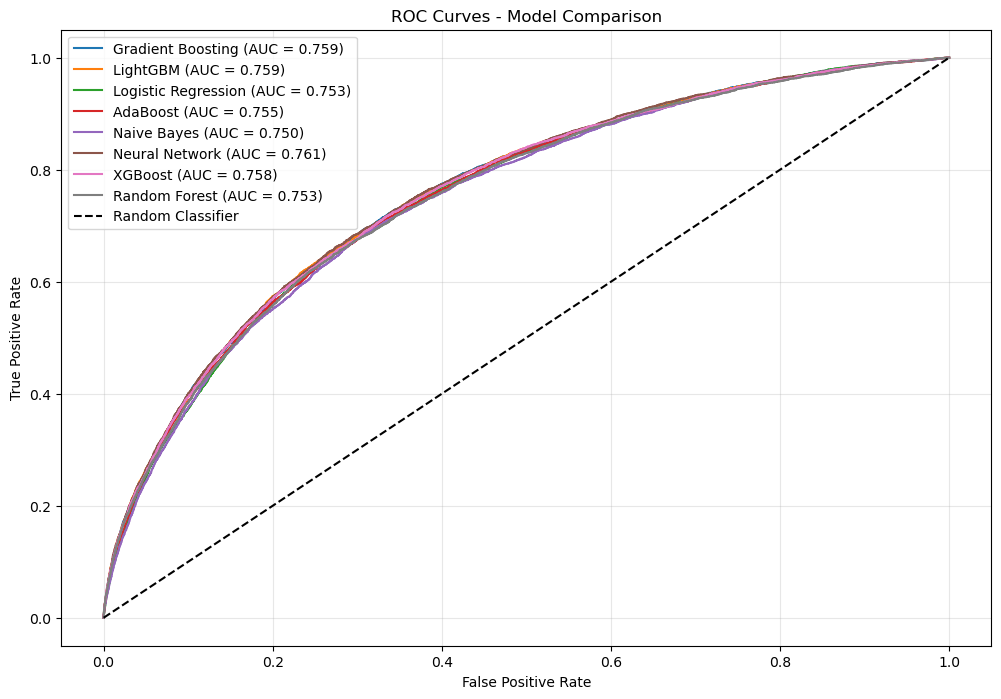

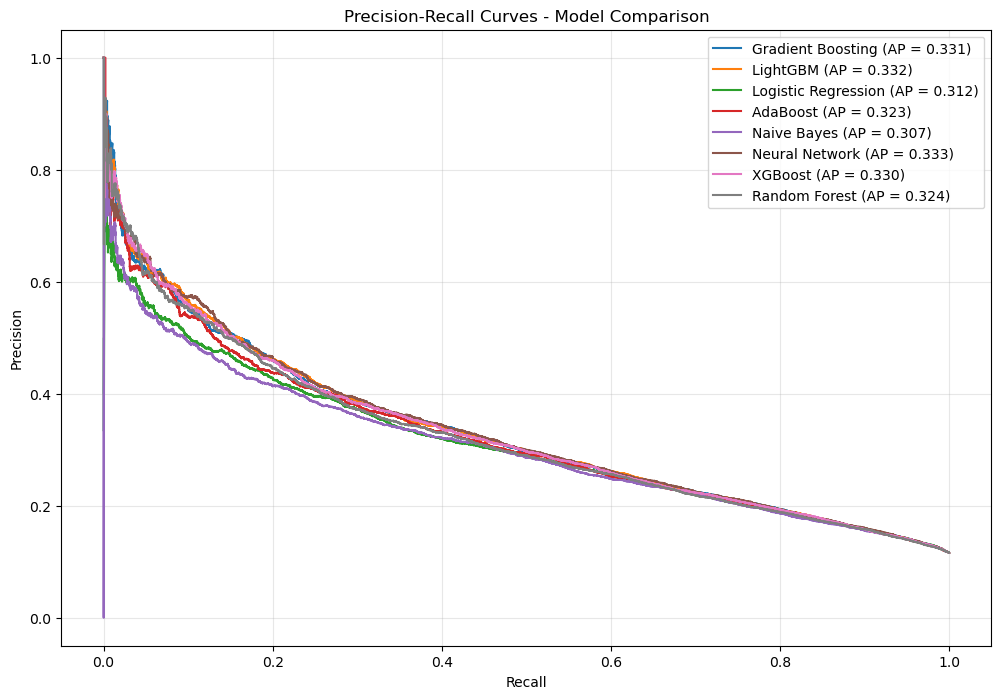

<Figure size 1200x800 with 0 Axes>

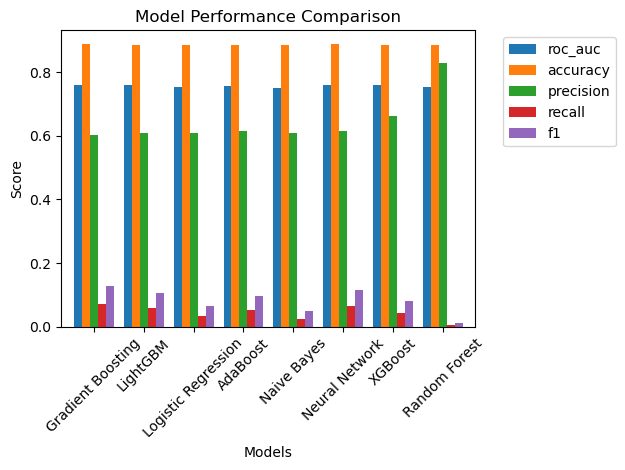

,roc_auc,accuracy,precision,recall,f1
Gradient Boosting,0.75906,0.886665,0.602289,0.070983,0.126998
LightGBM,0.759409,0.886254,0.609712,0.057157,0.104517
Logistic Regression,0.753107,0.885256,0.607903,0.033721,0.063898
AdaBoost,0.754561,0.886117,0.615694,0.051593,0.095208
Naive Bayes,0.74993,0.884923,0.608,0.025628,0.049183
Neural Network,0.760614,0.886607,0.613636,0.063733,0.115473
XGBoost,0.758017,0.886293,0.663158,0.042489,0.079861
Random Forest,0.75289,0.884472,0.829787,0.006576,0.013048


In [33]:
create_model_comparison_plots()